In [11]:
from google.colab import files
uploaded = files.upload()  # This will prompt you to upload the file


Saving Telco_customer_churn.csv to Telco_customer_churn.csv


In [4]:
import pandas as pd

# Load the dataset
file_path = "Telco_customer_churn.csv"  # Replace with your dataset path
data = pd.read_csv(file_path)

# Display the first few rows and column types
print("First few rows of the dataset:")
print(data.head())
print("\nDataset Information:")
print(data.info())


First few rows of the dataset:
   CustomerID  Count        Country       State         City  Zip Code  \
0  3668-QPYBK      1  United States  California  Los Angeles     90003   
1  9237-HQITU      1  United States  California  Los Angeles     90005   
2  9305-CDSKC      1  United States  California  Los Angeles     90006   
3  7892-POOKP      1  United States  California  Los Angeles     90010   
4  0280-XJGEX      1  United States  California  Los Angeles     90015   

                 Lat Long   Latitude   Longitude  Gender  ...        Contract  \
0  33.964131, -118.272783  33.964131 -118.272783    Male  ...  Month-to-month   
1   34.059281, -118.30742  34.059281 -118.307420  Female  ...  Month-to-month   
2  34.048013, -118.293953  34.048013 -118.293953  Female  ...  Month-to-month   
3  34.062125, -118.315709  34.062125 -118.315709  Female  ...  Month-to-month   
4  34.039224, -118.266293  34.039224 -118.266293    Male  ...  Month-to-month   

  Paperless Billing             Payme

In [5]:
# Drop irrelevant columns
data = data.drop(columns=['CustomerID', 'Lat Long', 'Churn Reason'], errors='ignore')

# Convert 'Total Charges' to numeric, handling errors
data['Total Charges'] = pd.to_numeric(data['Total Charges'], errors='coerce')

# Fill missing values in 'Total Charges' with median
data['Total Charges'] = data['Total Charges'].fillna(data['Total Charges'].median())


In [6]:
# One-hot encode categorical columns
data = pd.get_dummies(data, drop_first=True)

# Verify dataset after encoding
print("Dataset after encoding:")
print(data.head())


Dataset after encoding:
   Count  Zip Code   Latitude   Longitude  Tenure Months  Monthly Charges  \
0      1     90003  33.964131 -118.272783              2            53.85   
1      1     90005  34.059281 -118.307420              2            70.70   
2      1     90006  34.048013 -118.293953              8            99.65   
3      1     90010  34.062125 -118.315709             28           104.80   
4      1     90015  34.039224 -118.266293             49           103.70   

   Total Charges  Churn Value  Churn Score  CLTV  ...  Streaming TV_Yes  \
0         108.15            1           86  3239  ...             False   
1         151.65            1           67  2701  ...             False   
2         820.50            1           86  5372  ...              True   
3        3046.05            1           84  5003  ...              True   
4        5036.30            1           89  5340  ...              True   

   Streaming Movies_No internet service  Streaming Movies_Yes 

In [7]:
# Define features (X) and target (y)
X = data.drop(columns=['Churn Value'])  # Ensure the target column is excluded from features
y = data['Churn Value']

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check data dimensions
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (5634, 1165)
Test set shape: (1409, 1165)


In [8]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Resample the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Verify the new class distribution
print("Class distribution after SMOTE:")
print(y_train_resampled.value_counts())


Class distribution after SMOTE:
Churn Value
0    4139
1    4139
Name: count, dtype: int64


In [9]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Train the model on the resampled training data
rf_model.fit(X_train_resampled, y_train_resampled)

print("Random Forest model trained successfully!")


Random Forest model trained successfully!


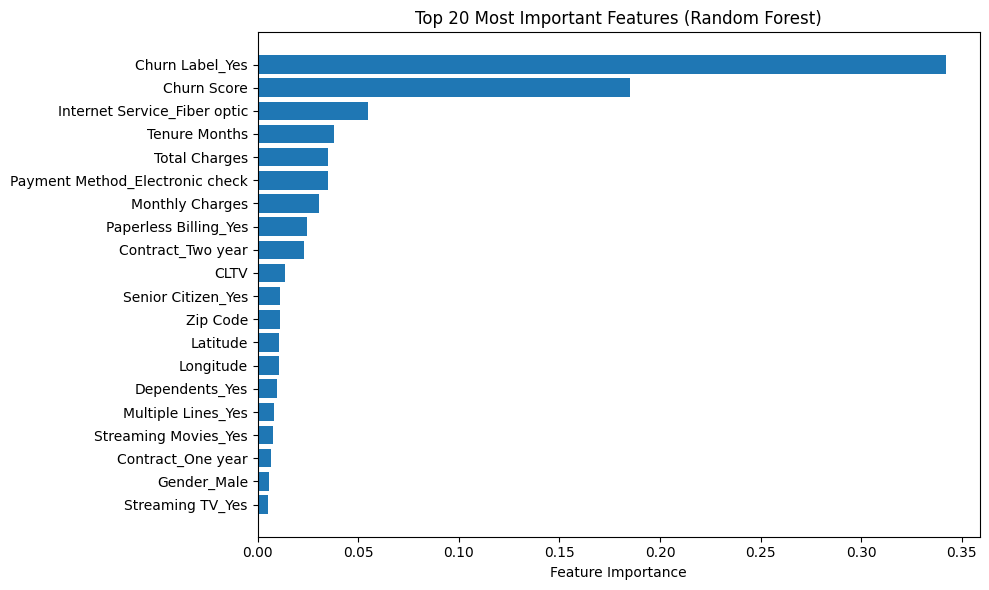

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Extract feature importances
feature_importances = rf_model.feature_importances_
feature_names = X_train.columns

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]

# Select top N features
N = 20  # Adjust N to show more or fewer features
top_indices = sorted_indices[:N]
top_features = np.array(feature_names)[top_indices]
top_importances = feature_importances[top_indices]

# Plot top feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_importances)), top_importances, align='center')
plt.yticks(range(len(top_importances)), top_features)
plt.xlabel("Feature Importance")
plt.title(f"Top {N} Most Important Features (Random Forest)")
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.tight_layout()
plt.show()


In [11]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Predict on the test set
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC Score
print("\nROC-AUC Score:", roc_auc_score(y_test, y_prob))


Confusion Matrix:
[[1035    0]
 [   0  374]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1035
           1       1.00      1.00      1.00       374

    accuracy                           1.00      1409
   macro avg       1.00      1.00      1.00      1409
weighted avg       1.00      1.00      1.00      1409


ROC-AUC Score: 1.0


In [12]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Initialize and train the SVM model
svm_model = SVC(random_state=42, probability=True)  # Enable probability estimation
svm_model.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred_svm = svm_model.predict(X_test)
y_prob_svm = svm_model.predict_proba(X_test)[:, 1]  # Get the probabilities for ROC AUC

# Confusion Matrix
print("SVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

# Classification Report
print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

# ROC-AUC Score
roc_auc_svm = roc_auc_score(y_test, y_prob_svm)
print(f"\nSVM ROC-AUC Score: {roc_auc_svm:.4f}")


SVM Confusion Matrix:
[[338 697]
 [ 49 325]]

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.33      0.48      1035
           1       0.32      0.87      0.47       374

    accuracy                           0.47      1409
   macro avg       0.60      0.60      0.47      1409
weighted avg       0.73      0.47      0.47      1409


SVM ROC-AUC Score: 0.6673


In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Define a smaller parameter grid for faster results
param_grid = {
    'C': [1, 10],  # Reduce number of values for regularization parameter C
    'kernel': ['linear'],  # Test only the 'linear' kernel for faster results
    'gamma': ['scale']  # Test only 'scale' for gamma
}

# Perform GridSearchCV with 3-fold cross-validation and parallel processing
grid_search = GridSearchCV(SVC(random_state=42, probability=True), param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fit the grid search on the resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Display the best parameters found by GridSearchCV
print("Best parameters from GridSearchCV:")
print(grid_search.best_params_)

# Train the best model
best_svm_model = grid_search.best_estimator_

# Evaluate the best SVM model on the test set
y_pred_best_svm = best_svm_model.predict(X_test)
y_prob_best_svm = best_svm_model.predict_proba(X_test)[:, 1]

# Confusion Matrix
print("\nBest SVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_svm))

# Classification Report
print("\nBest SVM Classification Report:")
print(classification_report(y_test, y_pred_best_svm))

# ROC-AUC Score
print(f"\nBest SVM ROC-AUC Score: {roc_auc_score(y_test, y_prob_best_svm):.4f}")


Best parameters from GridSearchCV:
{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}

Best SVM Confusion Matrix:
[[919 116]
 [ 26 348]]

Best SVM Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      1035
           1       0.75      0.93      0.83       374

    accuracy                           0.90      1409
   macro avg       0.86      0.91      0.88      1409
weighted avg       0.91      0.90      0.90      1409


Best SVM ROC-AUC Score: 0.9699


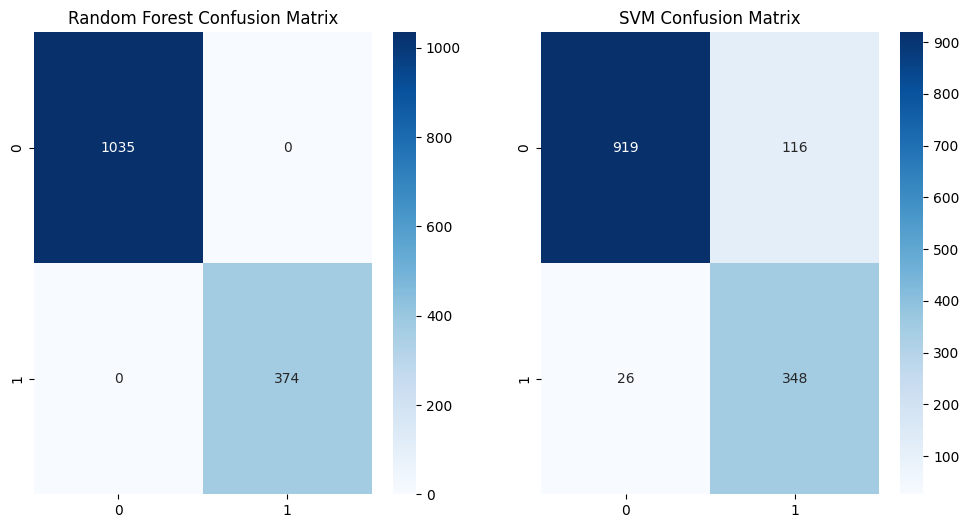

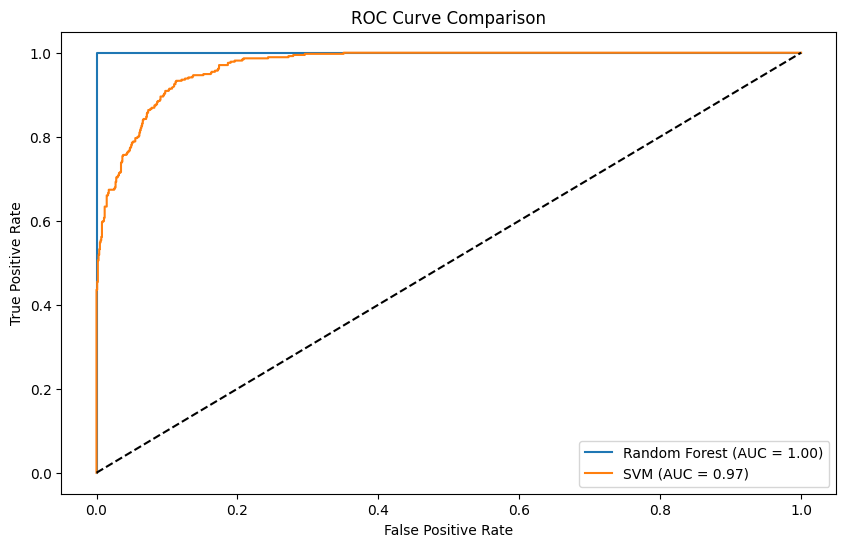

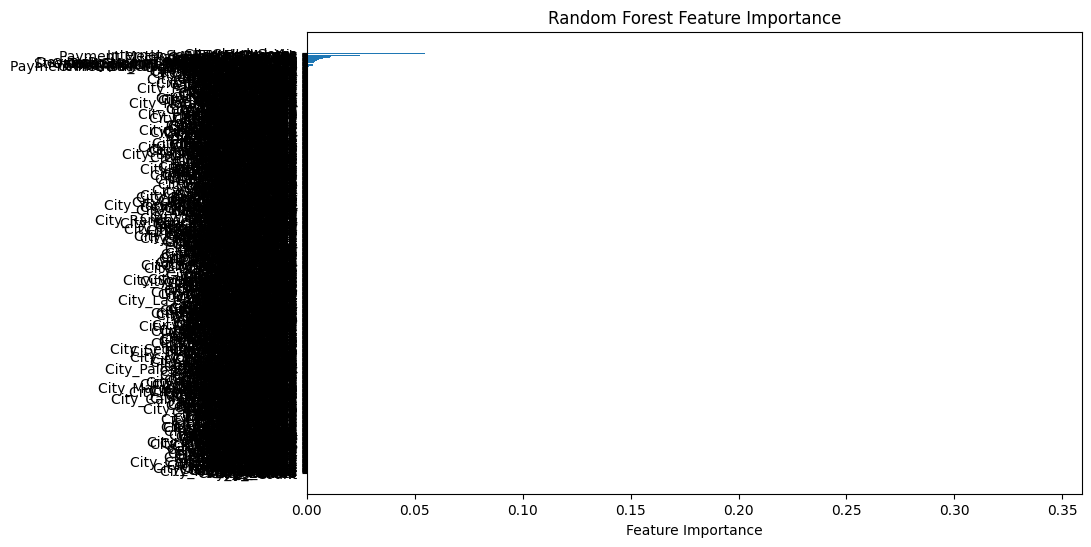

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1035
           1       1.00      1.00      1.00       374

    accuracy                           1.00      1409
   macro avg       1.00      1.00      1.00      1409
weighted avg       1.00      1.00      1.00      1409


Random Forest ROC-AUC Score: 1.0000

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      1035
           1       0.75      0.93      0.83       374

    accuracy                           0.90      1409
   macro avg       0.86      0.91      0.88      1409
weighted avg       0.91      0.90      0.90      1409


SVM ROC-AUC Score: 0.9699


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# --- Train Random Forest Model ---
# Initialize and train Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# --- Train SVM Model ---
# Define parameter grid for SVM
param_grid = {
    'C': [1, 10],
    'kernel': ['linear'],
    'gamma': ['scale']
}

# Perform GridSearchCV for SVM
grid_search = GridSearchCV(SVC(random_state=42, probability=True), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best SVM model
best_svm_model = grid_search.best_estimator_

# Predict on the test set
y_pred_svm = best_svm_model.predict(X_test)
y_prob_svm = best_svm_model.predict_proba(X_test)[:, 1]

# --- Evaluation Metrics ---
# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_svm = confusion_matrix(y_test, y_pred_svm)

# Classification Report
report_rf = classification_report(y_test, y_pred_rf)
report_svm = classification_report(y_test, y_pred_svm)

# ROC-AUC Scores
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
roc_auc_svm = roc_auc_score(y_test, y_prob_svm)

# --- Visualizations ---

# 1. Confusion Matrix Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", ax=ax[0])
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", ax=ax[1])
ax[0].set_title("Random Forest Confusion Matrix")
ax[1].set_title("SVM Confusion Matrix")
plt.show()

# 2. ROC Curves
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)

plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.2f})")
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {roc_auc_svm:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

# 3. Feature Importance (Only for Random Forest)
feature_importances = rf_model.feature_importances_
feature_names = X_train.columns

# Plot feature importance for Random Forest
sorted_indices = np.argsort(feature_importances)
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances[sorted_indices])
plt.yticks(range(len(feature_importances)), np.array(feature_names)[sorted_indices])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

# --- Print Evaluation Results ---
print("Random Forest Classification Report:")
print(report_rf)
print(f"\nRandom Forest ROC-AUC Score: {roc_auc_rf:.4f}")

print("\nSVM Classification Report:")
print(report_svm)
print(f"\nSVM ROC-AUC Score: {roc_auc_svm:.4f}")
